In [1]:
# Description
'''
・Drop rows with missing price values
・Create the following concat variables
    drive*fuel
    drive*condition
    drive*size
    fuel*condition
    fuel*size
    condition*size
・Conver manufacturer to lower case 
・Set unrealistic years to average year
・Treat extreme values in odometer to be outliers (1e10)
・Use the target encoding for all categorical variables
'''

'\n・Create the following concat variables\n drive*fuel\n drive*condition\n drive*size\n fuel*condition\n fuel*size\n condition*size\n\n・Use the target encoding for all categorical variables\n・Conver manufacturer to lower case \n'

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

In [334]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [338]:
def clean_data(orig_df):
    # Create a copy
    df_cleaned = orig_df.copy()

    # Use NaN for unrealistic year values
    df_cleaned.loc[df_cleaned['year'] > 2023, 'year'] = pd.NA
    df_cleaned['year_str'] = df_cleaned['year'].astype(str)

    # Handle negative and unrealistic odometer values
    df_cleaned.loc[(df_cleaned['odometer'] < 0) | (df_cleaned['odometer'] > 1e6), 'odometer'] = -99999

    # Make manufacturer lowercase
    df_cleaned['manufacturer'] = df_cleaned['manufacturer'].str.lower()

    # feature creation
    df_cleaned['drive_fuel_condition'] = df_cleaned['drive'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['condition']
    df_cleaned['fuel_paint_color'] = df_cleaned['fuel'] + '_' + df_cleaned['paint_color']
    df_cleaned['drive_paint_color'] = df_cleaned['drive'] + '_' + df_cleaned['paint_color']
    df_cleaned['drive_fuel_size'] = df_cleaned['drive'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['size']
    df_cleaned['drive_fuel_paint_color'] = df_cleaned['drive'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['paint_color']
    df_cleaned['drive_condition_size'] = df_cleaned['drive'] + '_' + df_cleaned['condition'] + '_' + df_cleaned['size']
    df_cleaned['drive_condition_paint_color'] = df_cleaned['drive'] + '_' + df_cleaned['condition'] + '_' + df_cleaned['paint_color']
    df_cleaned['drive_size_paint_color'] = df_cleaned['drive'] + '_' + df_cleaned['size'] + '_' + df_cleaned['paint_color']
    df_cleaned['fuel_condition_size'] = df_cleaned['fuel'] + '_' + df_cleaned['condition'] + '_' + df_cleaned['size']
    df_cleaned['fuel_condition_paint_color'] = df_cleaned['fuel'] + '_' + df_cleaned['condition'] + '_' + df_cleaned['paint_color']
    df_cleaned['fuel_size_paint_color'] = df_cleaned['fuel'] + '_' + df_cleaned['size'] + '_' + df_cleaned['paint_color']
    df_cleaned['type_condition'] = df_cleaned['type'] + '_' + df_cleaned['condition']
    df_cleaned['type_size'] = df_cleaned['type'] + '_' + df_cleaned['size']
    df_cleaned['type_paint_color'] = df_cleaned['type'] + '_' + df_cleaned['paint_color']
    df_cleaned['type_fuel_condition'] = df_cleaned['type'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['condition']
    df_cleaned['type_fuel_size'] = df_cleaned['type'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['size']
    df_cleaned['type_condition_size'] = df_cleaned['type'] + '_' + df_cleaned['condition'] + '_' + df_cleaned['size']
    df_cleaned['type_condition_paint_color'] = df_cleaned['type'] + '_' + df_cleaned['condition'] + '_' + df_cleaned['paint_color']
    df_cleaned['year_manufacturer'] = df_cleaned['year_str'] + '_' + df_cleaned['manufacturer']
    df_cleaned['year_condition'] = df_cleaned['year_str'] + '_' + df_cleaned['condition']
    df_cleaned['year_size'] = df_cleaned['year_str'] + '_' + df_cleaned['size']
    df_cleaned['year_paint_color'] = df_cleaned['year_str'] + '_' + df_cleaned['paint_color']
    df_cleaned['year_fuel_condition'] = df_cleaned['year_str'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['condition']
    df_cleaned['year_fuel_size'] = df_cleaned['year_str'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['size']
    df_cleaned['year_fuel_paint_color'] = df_cleaned['year_str'] + '_' + df_cleaned['fuel'] + '_' + df_cleaned['paint_color']
    df_cleaned['year_condition_size'] = df_cleaned['year_str'] + '_' + df_cleaned['condition'] + '_' + df_cleaned['size']
    df_cleaned['year_drive_condition_paint_color'] = df_cleaned['year_str'] + df_cleaned['drive'] + '_' + df_cleaned['condition'] + '_' + df_cleaned['paint_color']
    df_cleaned['year*odometer'] = df_cleaned['year'] * df_cleaned['odometer']

    return df_cleaned

train_df_ = clean_data(train_df)
test_df_ = clean_data(test_df)

In [339]:
# Target encoding for categorical features
cat_cols = train_df_.select_dtypes(include=['object']).columns
for column in cat_cols:
    # test data target encoding
    data_tmp = pd.DataFrame({column: train_df_[column], 'price': train_df_['price']})
    target_mean = data_tmp.groupby(column)['price'].mean()
    test_df_[column] = test_df_[column].map(target_mean)

    # train data target encoding
    tmp = test_df_[column].map(target_mean)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for idx1, idx2 in kf.split(train_df_):
        target_mean = data_tmp.iloc[idx1].groupby(column)['price'].mean()
        tmp[idx2] = train_df_[column].iloc[idx2].map(target_mean)
        
    train_df_[column] = tmp

In [244]:
# Label Encoding
train_df_ = train_df.copy()
le = preprocessing.LabelEncoder()
cat_cols = train_df_.select_dtypes(include=['object']).columns
for col in cat_cols:
    train_df_[col] = le.fit_transform(train_df_[col].astype(str))
    test_df_[col] = le.fit_transform(test_df_[col].astype(str))

In [340]:
# data splitting
target = train_df_['price']
train_df_for_learning = train_df_.drop(['id', 'fuel', 'condition', 'size', 'transmission', 'title_status', 'price'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(train_df_for_learning, target, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(20649, 38) (6883, 38) (20649,) (6883,)


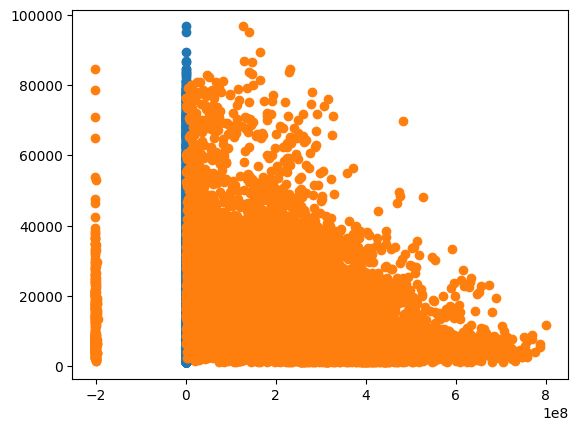

In [341]:
#sns.heatmap(train_df_.corr(), square=True, vmax=1, vmin=-1, center=0)
plt.scatter(train_df_['drive_condition_paint_color'], train_df_['price'])
plt.scatter(train_df_['year*odometer'], train_df_['price'])
plt.show()

c:\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8050
[LightGBM] [Info] Number of data points in the train set: 20649, number of used features: 38
[LightGBM] [Info] Start training from score 13476.656303
65.86016433128786


,importance
year_fuel_size,9.713260e+11
drive_condition_paint_color,6.928979e+11
odometer,4.281818e+11
year*odometer,2.818978e+11
year_manufacturer,2.473640e+11
type_condition_paint_color,2.246587e+11
year_fuel_condition,1.599660e+11
region,1.304243e+11
type_condition_size,1.145403e+11
state,1.063561e+11


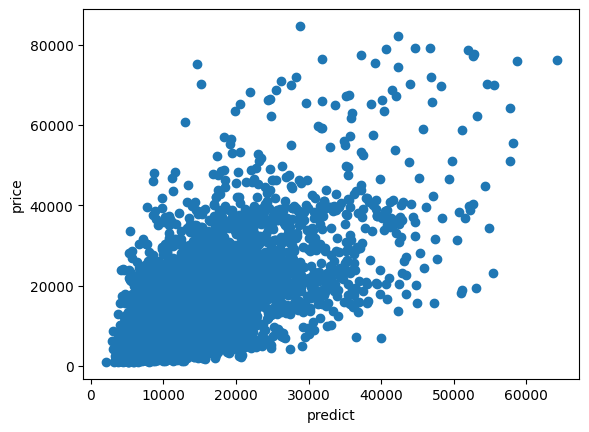

In [342]:
# learning
train_set = lgbm.Dataset(X_train, y_train)
valid_set = lgbm.Dataset(X_valid, y_valid)
params = {'objective': 'regression',
          'metric': 'mae',
          'num_iterations': 100,
          'learning_rate': 0.1,
          'feature_fraction': 0.75,
          "bagging_freq": 20, 
          "bagging_fraction": 0.5
          }
          
model = lgbm.train(params = params, 
                   train_set = train_set,
                   valid_sets = [train_set, valid_set])

pred = model.predict(X_valid)
score = mean_absolute_percentage_error(y_valid, pred)
print(score*100)
plt.scatter(pred, y_valid)
plt.xlabel('predict')
plt.ylabel('price')

importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X_train.columns, columns=['importance'])
display(importance.sort_values('importance', ascending=False))

In [202]:
# submit
predict = model.predict(test_df_)
submit = pd.read_csv("data/submit_sample.csv", header=None)
submit[1] = predict
submit.to_csv("submission.csv", index=False, header=None)